In [141]:
## load in relevant packages
%matplotlib inline
#import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
import pandas as pd  
import numpy as np
import gpflow
import math as ma
from sklearn.preprocessing import StandardScaler  
feature_scaler = StandardScaler()

np.random.seed(5)

## set max number
N = 100
## set number of sensor locations to find
k = 8
## set percent of N to train on
perc = .10

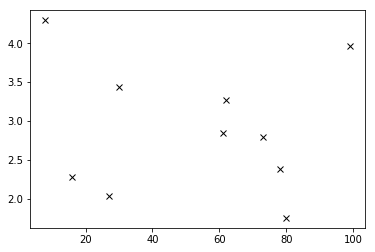

In [142]:
## create subset size for the trained data
sub = ma.ceil(perc*N)
## create fake data for model
noiseSize = 0.05

## define X values (integers from 0 to N)
X = np.arange(0,N+1,1)
## take sample for training
x_train = np.random.randint(0,N,sub)
x_train = x_train.reshape(-1,1)
x_train = x_train.astype(float)
y_train = np.sin(12*x_train) + 0.66*np.cos(25*x_train)  + np.random.randn(sub,1)*noiseSize + 3

## plot distribution of selected sensors
plt.plot(x_train, y_train, 'kx')

In [143]:
## build model
kernel = gpflow.kernels.RBF(1, active_dims=[0], lengthscales=1.0)
## build model
m = gpflow.models.GPR(x_train, y_train, kern=kernel)
m.likelihood.variance = 0.01

## view 
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.01


In [144]:
gpflow.train.ScipyOptimizer().minimize(m)
print(m.as_pandas_table())

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 18.673653
  Number of iterations: 19
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 18.673653
  Number of iterations: 19
  Number of functions evaluations: 22


                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                value  
GPR/kern/lengthscales           True   12.249929783108312  
GPR/kern/variance               True   10.752711275527057  
GPR/likelihood/variance         True  0.12279649439486567  


In [145]:
## example: thought exercise
## 5 sensor locations: S = [4,5,6,7,8]
## total number of sensors to find: k = 2
## for each iteration (1:k):
    ## for each possible sensor location (y) not in A (S):
        ## calculate: corr(y)^2 - corr(yA)*np.linalg.inv(corr(AA))*corr(Ay) / corr(y)^2 - corr(ynA)*np.linalg.inv(corr(nAA))*corr(nAy)
    ## select max(store_val)
    ## append y to A

    
## selected sensors (indices)
A = np.array([],dtype=int)
## number of sensors to find
k = k
## define x_new as the new points not used for training
x_new = np.setdiff1d(X, x_train)
x_new = x_new.reshape(-1,1)
## define S as the incides of x_new
S = np.arange(0,x_new.shape[0]).reshape(x_new.shape[0],1)    

In [146]:
## x is np.array or single value
def generate_cov_mat(x):
    if not isinstance(x, np.ndarray):
        x = np.array(x).reshape(-1,1)
    ## select the 2nd object and bring up one dimension
    cov_mat = m.predict_f_full_cov(x)[1][0,:,:]
    return(cov_mat)

In [153]:
def pick_best_sensors_krause(S, X, k, A, verbose=False):

    ## take out locations already in A before checks
    S = S[np.isin(S, A, invert=True)]
    
    ## checks
    if k > S.shape[0]:
        print("error! k must be smaller than S")
        return
    if k/S.shape[0] > 0.25:
        print("Recommendation: k should be a significantly small fraction of S")
    
    ## print statements
    print("finding " + str(k) + " sensor locations of " + str(S.shape[0]) + " possible locations")
    
    ## next version: 
    ## add S + U
    ## add for 2-d, 3-d, etc
    
    ## create definition to generate model
    
    ## later version:
    ## use one full matrix and subset from
    
    ## additional checks:
    ## length of A + k should be less than S
    
    
    ## for each sensor to be added:
    for j in range(k):
        ## find the indices of coordinates not already in A to iterate through
        Y = S[np.isin(S, A, invert=True)]
        ## store the calculated value for each potential coordinate in order to take the max
        delta = np.array([])
        ## print iteration
        print("Starting iteration: " + str(j))
    
        for y in Y:
            ## define how many sensor sites already exist
            len_A = A.shape[0]
            ## combine indices of y and A
            yA = np.append(np.array([y]), A, axis=0)
            ## collect values of y and A using the indices
            yA_val = X[yA,:].reshape(yA.shape[0],X.shape[1])
            
            ## define the rest of possible sites taking out y and A
            nyA = S[np.isin(S, yA, invert=True)]
            len_nA = nyA.shape[0]
            ## define the indices of locations not in yA
            nyA = np.append(np.array([y]), nyA, axis=0)
            ## collect values of y and nA using the indices
            nyA_val = X[nyA,:].reshape(nyA.shape[0],X.shape[1])

            ## generate the covariance matrix:
            ##    y  A1  A2  ...
            ## y
            ## A1
            ## A2
            ## ...
            cov_mat_A = generate_cov_mat(yA_val)
            ## select y's covariance
            y_cov = cov_mat_A[:1,[0]]
            ## grab covariance values
            if len_A > 0:
                AA_cov = np.linalg.inv(cov_mat_A[1:len_A+1, 1:len_A+1])
                yA_cov = cov_mat_A[[0],1:len_A+1]
                Ay_cov = yA_cov.T
                calc_1 = y_cov**2 - np.dot(np.dot(yA_cov, AA_cov), Ay_cov)
            ## if A is empty: ignore the 2nd part of the calculation
            else:
                calc_1 = y_cov**2
            
            cov_mat_nA = generate_cov_mat(nyA_val)
            nAA_cov = np.linalg.pinv(cov_mat_nA[1:len_nA+1, 1:len_nA+1])
            nyA_cov = cov_mat_nA[[0],1:len_nA+1]
            nAy_cov = nyA_cov.T
            calc_2 = y_cov**2 - np.dot(np.dot(nyA_cov, nAA_cov), nAy_cov)
            
            value = calc_1 / calc_2
            delta = np.append(delta, value)
            
        ## find the index with the largest delta
        y_star = np.array(Y[np.argmax(delta)])
        ## append to A as a new sensor site
        A = np.append(A, y_star)
        
        if verbose == True:
            #print(Y)
            #print(delta)
            print("Max value: " + str(np.amax(delta)))
            print("Picking sensor site: " + str(y_star))
    
    A_sites = X[A,:]
    return(A_sites)

In [154]:
best_sensors = pick_best_sensors_krause(S=S, X=x_new, k=k, A=A, verbose=False)
print(best_sensors)

finding 8 sensor locations of 91 possible locations
Starting iteration: 0
Starting iteration: 1
Starting iteration: 2
Starting iteration: 3
Starting iteration: 4
Starting iteration: 5
Starting iteration: 6
Starting iteration: 7
[[ 2]
 [36]
 [55]
 [56]
 [ 0]
 [57]
 [38]
 [35]]


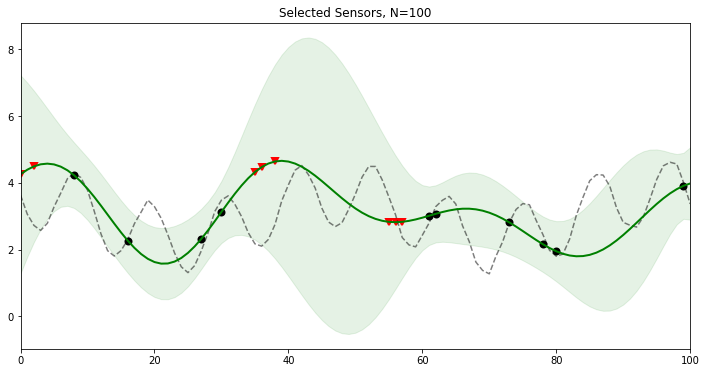

In [155]:
## WORKS ONLY FOR 1-D DATA
def plot(m, N):
    ## true underlying function: dashed line
    ## mean: green line
    ## shade: sd
    ## training points: black dots
    ## selected sensor points: red triangles
    xx = np.linspace(0, N, N+1)[:,None]
    ## actual function
    yy = np.sin(12*xx) + 0.66*np.cos(25*xx)  + np.random.randn(N+1,1)*noiseSize + 3
    ## predict values
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    
    mean_train, var_train = m.predict_y(x_train)
    plt.plot(x_train, mean_train, 'ko', mew=2)
    
    mean_sensors, var_sensors = m.predict_y(best_sensors)
    plt.plot(best_sensors, mean_sensors, 'rv', mew=2)
    
    plt.plot(xx, yy, 'k--', alpha=0.5)
    plt.plot(xx, mean, 'g', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='green', alpha=0.1)
    plt.xlim(0, N)
    plt.title('Selected Sensors, N=' + str(N))
    plt.savefig('../figures/selected_sensors_' + str(N))
plot(m, N)

In [ ]:
## fake data
## random int X and NO2 concentration Y works!
#X = np.random.randint(50, size=(20, 2)).astype(float)
## so does this...
#X = np.random.normal(size=(20,2))
#print(X.shape)
#print(X)
#dta = pd.read_csv("../data/kcl_london_model_data_winter_collapsed.csv", sep=',') 
#y = dta.loc[:,'nox'].values
#y = y.reshape(-1,1)

In [126]:
## aggregated over time
dta = pd.read_csv("../data/kcl_london_model_data_winter_collapsed.csv", sep=',') 
print(dta.shape)
params = ['latitude', 'longitude']

#dta = pd.read_csv("../data/kcl_london_model_data_winter_agg_time.csv", sep=',')
#print(dta.shape)
#params = ['latitude', 'longitude', 'year']


X = dta[params].values
print(X.shape)
## rescale lat/long and year data
## scaling the data causes the determinant to be 0 for the matrix
X = feature_scaler.fit_transform(X)
y = dta.loc[:,'nox'].values
y = y.reshape(-1,1)

(230, 6)
(230, 2)


In [127]:
#print(X.shape)
#unique_elements = np.unique(X)
#print(unique_elements[0:5])

In [128]:
## set max number
N = 200
## set number of sensor locations to find
k = 5
## set percent of N to train on
#perc = .10
perc = .75

In [129]:
## subset to the trained data
sub = ma.ceil(perc*N)
print(sub)

150


In [130]:
## take the first sub coordinates for training
x_samps = np.arange(0,sub)
print(x_samps)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]


In [131]:
## take sample for training
#x_samps = np.random.randint(X.shape[0], size=sub)

x_train = X[x_samps,:]
y_train = y[x_samps,:]
## standardize y-values
y_train = feature_scaler.fit_transform(y_train)

print(x_train.shape)
print(y_train.shape)

(150, 2)
(150, 1)


In [132]:
## build model
kernel = gpflow.kernels.RBF(2, active_dims=[0,1], lengthscales=1.0)
#kernel = gpflow.kernels.RBF(2, active_dims=[0,1], lengthscales=1.0) *\
#            gpflow.kernels.RBF(1 , active_dims=[2], lengthscales=0.1)

## build model
m = gpflow.models.GPR(x_train, y_train, kern=kernel)
m.likelihood.variance = 0.01

## view 
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.01


In [133]:
## Run Model
## Marginal Liklihood Maximization
## picks the most simple model that picks the data the best
gpflow.train.ScipyOptimizer().minimize(m)
print(m.as_pandas_table())

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 187.303603
  Number of iterations: 24
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 187.303603
  Number of iterations: 24
  Number of functions evaluations: 30


                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                value  
GPR/kern/lengthscales           True  0.07998672282018847  
GPR/kern/variance               True   0.8488263940940741  
GPR/likelihood/variance         True  0.17006121493441734  


In [134]:
## define x-values not used for training
## iterate all of X
#X_iter = np.arange(0,X.shape[0])
## take out the iters already used for training
#x_new = np.setdiff1d(X_iter, x_samps)
#x_new_samps = np.arange(sub+2,sub+2+N+1)
x_new_samps = np.arange(sub+20, sub+30+20)
print(x_new_samps)
## randomly select new iterations from the list
#x_new_samps = np.random.choice(x_new, N-sub, replace=False)
#print(x_samps)
#print(x_new_samps)
x_new = X[x_new_samps,:]
print(x_new.shape)
print(x_new[0:5])
#print(x_samps)

[170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199]
(30, 2)
[[-0.00263313  2.11205839]
 [ 1.1921595   2.23867898]
 [-0.40492131  2.28529385]
 [-0.35825125 -2.23719005]
 [-0.15215749 -2.19549761]]


In [135]:
## selected sensors (indices)
A = np.array([],dtype=int)
## number of sensors to find
k = k
## define S as the incides of x_new
S = np.arange(0,x_new.shape[0]).reshape(x_new.shape[0],1) 

In [136]:
## x is np.array or single value
def generate_cov_mat(x):
    if not isinstance(x, np.ndarray):
        x = np.array(x).reshape(-1,1)
    cov_mat = m.predict_f_full_cov(x)[1][0,:,:]
    return(cov_mat)

In [137]:
from scipy.linalg import det

In [138]:
print(x_new.shape)
#print(X[0,:])

(30, 2)


In [139]:
def pick_best_sensors_krause(S, X, k, A, verbose=False):

    ## take out locations already in A before checks
    #S = S[np.isin(S, A, invert=True)]
    
    ## checks
    if k > S.shape[0]:
        print("error! k must be smaller than S")
        return
    if k/S.shape[0] > 0.25:
        print("Recommendation: k should be a significantly small fraction of S")
    
    ## print statements
    print("finding " + str(k) + " sensor locations of " + str(S.shape[0]) + " possible locations")
    
    ## next version: 
    ## add S + U
    ## add for 2-d, 3-d, etc
    
    ## create definition to generate model
    
    ## later version:
    ## use one full matrix and subset from
    
    ## additional checks:
    ## length of A + k should be less than S
    
    
    ## for each sensor to be added:
    for j in range(k):
        ## find the indices of coordinates not already in A to iterate through
        Y = S[np.isin(S, A, invert=True)]
        ## store the calculated value for each potential coordinate in order to take the max
        delta = np.array([])
        ## print iteration
        print("Starting iteration: " + str(j))
    
        for y in Y:
            #print(y)
            ## define how many sensor sites already exist
            len_A = A.shape[0]
            #print(len_A)
            ## combine indices of y and A
            yA = np.append(np.array([y]), A, axis=0)
            #print(yA)
            ## collect values of y and A using the indices
            #print(X.shape)
            #print(X[0:5,])
            yA_val = X[yA,:].reshape(yA.shape[0],X.shape[1])
            #print(X[yA,:].shape)
            #print(yA_val.shape)
            
            ## define the rest of possible sites taking out y and A
            nyA = S[np.isin(S, yA, invert=True)]
            len_nA = nyA.shape[0]
            ## define the indices of locations not in yA
            nyA = np.append(np.array([y]), nyA, axis=0)
            ## collect values of y and nA using the indices
            nyA_val = X[nyA,:].reshape(nyA.shape[0],X.shape[1])

            ## generate the covariance matrix:
            ##    y  A1  A2  ...
            ## y
            ## A1
            ## A2
            ## ...
            cov_mat_A = generate_cov_mat(yA_val)
            ## select y's covariance
            y_cov = cov_mat_A[:1,[0]]
            ## grab covariance values
            if len_A > 0:
                AA_cov = np.linalg.inv(cov_mat_A[1:len_A+1, 1:len_A+1])
                yA_cov = cov_mat_A[[0],1:len_A+1]
                Ay_cov = yA_cov.T
                calc_1 = y_cov**2 - np.dot(np.dot(yA_cov, AA_cov), Ay_cov)
            ## if A is empty: ignore the 2nd part of the calculation
            else:
                calc_1 = y_cov**2
            
            cov_mat_nA = generate_cov_mat(nyA_val)
            #print(nyA_val.shape)
            #print(nyA_val[0:5,])
            #if np.linalg.det(cov_mat_nA) == 0:
            #    print("determinant of cov_mat_nA = 0!")
            #    print("other determinant of cov_mat_nA = " + str(det(cov_mat_nA)))
            #print(cov_mat_nA.shape)
            #print(cov_mat_nA)
            
            #nAA_cov = np.linalg.inv(cov_mat_nA[1:len_nA+1, 1:len_nA+1])
            nAA_cov = np.linalg.pinv(cov_mat_nA[1:len_nA+1, 1:len_nA+1])
            nyA_cov = cov_mat_nA[[0],1:len_nA+1]
            nAy_cov = nyA_cov.T
            calc_2 = y_cov**2 - np.dot(np.dot(nyA_cov, nAA_cov), nAy_cov)
            
            value = calc_1 / calc_2
            delta = np.append(delta, value)
            
        ## find the index with the largest delta
        y_star = np.array(Y[np.argmax(delta)])
        ## append to A as a new sensor site
        A = np.append(A, y_star)
        
        if verbose == True:
            #print(Y)
            #print(delta)
            print("Max value: " + str(np.amax(delta)))
            print("Picking sensor site: " + str(y_star))
    
    A_sites = X[A,:]
    return(A_sites)

In [140]:
#print(S.shape)
#print(x_new.shape)
best_sensors = pick_best_sensors_krause(S=S, X=x_new, k=k, A=A, verbose=False)
print(best_sensors)

finding 5 sensor locations of 30 possible locations
Starting iteration: 0
Starting iteration: 1
Starting iteration: 2
Starting iteration: 3
Starting iteration: 4
[[-0.022188   -0.24036455]
 [ 0.09351593 -0.41960166]
 [-0.15215749 -2.19549761]
 [-0.42045239 -0.38838507]
 [ 1.79873542 -0.09795126]]
